<a href="https://colab.research.google.com/github/Lu-David/CovariateShift/blob/main/MNIST_RBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Data

In [ ]:
import torchvision
import torchvision.datasets as datasets
import torch

In [ ]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



tensor(5)


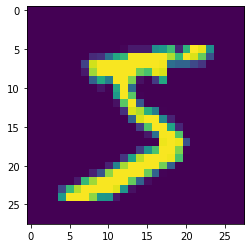

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

plt.imshow(mnist_trainset.data[0])
print(mnist_trainset.targets[0])

# Util Functions and Classes


In [ ]:
def unison_shuffled_copies(a, b):
  # Shuffle both arrays in unison
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

## Model

In [ ]:
import torch.nn as nn


class RBAGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, output, r_st):
        pred = torch.sigmoid(output * r_st)
        ctx.save_for_backward(pred)
        return pred

    @staticmethod
    def backward(ctx, y):
        prob, = ctx.saved_tensors
        grad_temp = y.clone()
        grad_input = (prob - grad_temp)
        return grad_input, None
        
class RBAClassifierMLP(nn.Module):
    """
    Multi (3) layer robust bias aware (RBA) classifier
    """
    def __init__(self, in_features = 2, out_features = 1, bias = True):
        super(RBAClassifierMLP, self).__init__()

        self.activation = nn.Sigmoid()
        self.layer1 = nn.Linear(in_features, 16, bias = bias)
        # self.layer2 = nn.Linear(16, 16)
        self.layer3 = nn.Linear(16, out_features)

    def forward(self, input, r_st):
        """[summary]

        Args:
            input (torch.Tensor): features

        Returns:
            torch.Tensor: predictions
        """
        output = self.activation(self.layer1(input))
        # output = self.activation(self.layer2(output))
        output = self.layer3(output)

        return RBAGrad.apply(output, r_st)

## Train

In [ ]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

def get_param_grad_avg(model):
  summ = 0
  maxx = 0
  minn = torch.Tensor(100000)
  num_params = get_n_params(model)

  for name, param in model.named_parameters():
    if param.requires_grad:
      grad = torch.abs(param.grad)
      summ += torch.sum(grad)
      maxx = max(maxx, torch.max(grad))
  return summ / num_params, maxx        

In [ ]:
import torch
import torch.nn as nn
import numpy as np


def rba_train(X_s, y_s, r_st, r_ts, max_itr = 10000, lr = 0.01, weight_decay = 0, min_grad = 0.001):
    # General function for training RBA, IW, or LOG models

    temperature = nn.Parameter(torch.ones(1).cuda())

    _, n_col = X_s.shape
    _, out_features = y_s.shape

    # bias = True
    # if True: # not torch.equal(r_ts, torch.ones(r_ts.shape)):
    bias = False
    X = torch.cat((
        torch.ones(r_ts.shape), 
        X_s
    ), dim = 1)
    
    model = RBAClassifierMLP(in_features = n_col + int(not bias), out_features=out_features, bias = bias)
        
    loss_fn = nn.BCELoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

    F = X * r_ts.detach()

    model.train()

    for i in range(max_itr + 1): 
        optimizer.zero_grad()
        
        outputs = model.forward(F, r_st)
        outputs.backward(y_s)
        optimizer.step()
        
        loss = loss_fn(outputs.squeeze(), y_s.squeeze())
        if i % 1000 == 0:
            # print(f"Loss at step {i}: {float(loss.data)}")
            avg, maxx = get_param_grad_avg(model)
            print(f"Grad avg: {avg}. Grad max: {maxx}")
            if avg < min_grad:
              break
            
    return model

## TODO: Calibration: Temperature Scaling

In [ ]:
def T_scaling(logits, temperature):
  return torch.div(logits, temperature)

In [ ]:
from torch import optim 

def get_temp_scale(model, X_t, y_t, r_st):
  temperature = nn.Parameter(torch.ones(1).cuda())
  args = {'temperature': temperature}
  criterion = nn.BCELoss()

  # Removing strong_wolfe line search results in jump after 50 epochs
  optimizer = optim.LBFGS([temperature], lr=0.001, max_iter=1000, line_search_fn='strong_wolfe')

  logits_list = []
  labels_list = []
  temps = []
  losses = []

  def _eval():
    loss = criterion(T_scaling(logits_list, args), labels_list)
    loss.backward()
    temps.append(temperature.item())
    losses.append(loss)
    return loss


  optimizer.step(_eval)



## Test

In [ ]:
def log_test(model, X_t, y_t, r_st, calibration_method=None):
    n_row, _ = X_t.shape
    
    model.eval()
    loss_fn = nn.BCELoss() 

    F = torch.cat((
        torch.ones(r_st.shape), 
        X_t
        ), dim = 1)
    preds = []
    labels_oneh = []

    outputs = model(F, r_st)
    if calibration_method:
      pred = calibration_method(outputs)

    loss = loss_fn(outputs.squeeze(), y_t.squeeze())
    acc = torch.sum(torch.round(outputs) == y_t) / n_row
    print(f"Target Loss: {loss}. Target Accuracy: {acc}")
    return loss, outputs, acc

In [ ]:
def binary_ece(predictions, actual, n_bins = 10):
  '''
    Calculate Expected Calibration Error (ECE) of predictions and true labels
    https://jamesmccaffrey.wordpress.com/2021/01/22/how-to-calculate-expected-calibration-error-for-multi-class-classification/ 

            Parameters:
                    pred_y_pairs ((n by 2) np.array): Two columns where first column is predicted values and second column is true labels 
                    n_bins (int): number of bins to partition [0, 1] by

            Returns:
                    binary_sum (str): Binary string of the sum of a and b
    '''
  pred_y_pairs = torch.cat((predictions, actual), dim=1).detach().numpy()
  bin_size = 1 / n_bins
  x = np.linspace(0, 1 - bin_size, n_bins)
  diff_array = np.zeros((n_bins))
  acc_array = np.zeros((n_bins))
  pos_freq_array = np.zeros((n_bins))
  count_array = np.zeros((n_bins))

  for i in range(n_bins):
    lower = i * bin_size
    upper = (i + 1) * bin_size
    
    temp = pred_y_pairs[np.logical_and(pred_y_pairs[:,0] >= lower, pred_y_pairs[:,0] < upper)]
    n = len(temp)

    count_array[i] = n
    acc = np.sum(np.round(temp[:, 0]) == temp[:, 1]) / n
    pos_freq = np.sum(1 == temp[:, 1]) / n
    avg_conf = np.mean(temp[:, 0])
    diff = np.abs(acc - avg_conf)
    
    diff_array[i] = diff
    acc_array[i] = acc
    pos_freq_array[i] = pos_freq

  
  ece = np.sum((diff_array * count_array)) / len(pred_y_pairs)

  # # Plot Reliability Diagram (pos_freq vs bins)
  # plt.bar(x, pos_freq_array, width=bin_size, align='edge')
  # plt.title(f"Reliability Diagram. ECE: {ece}")
  # plt.xlabel("Mean Predicted Value")
  # plt.xlabel("Fraction of positives")

  return ece


In [ ]:
# test_X_flattened = torch.flatten(torch.Tensor(test_X), start_dim=1)
# test_Y = torch.Tensor(test_Y)
# n, _ = test_X_flattened.shape
# r_st = torch.ones((n, 1))

# loss, outputs, acc = log_test(model, test_X_flattened, test_Y, torch.ones((test_X_flattened.shape[0], 1)))

# low_conf_samples = test_X[np.where(np.abs(outputs.detach().numpy() - 0.5) < 0.15)[0]]
# low_conf_labels = test_Y[np.where(np.abs(outputs.detach().numpy() - 0.5) < 0.15)[0]]

# i = 2
# j = 2
# fig, ax = plt.subplots(i,j)
# for x in range(i):
#   for y in range(j):
#     ax[x][y].imshow(low_conf_samples[x * i + y])
#     ax[x][y].title.set_text(int(low_conf_labels[x * i + y].item()))

# # fig.set_tight_layout(True)
# print(len(low_conf_labels))
# pred_y_pairs = np.concatenate((outputs.detach().numpy(), test_Y.detach().numpy()), axis=1)
# ece = binary_ece(pred_y_pairs, n_bins=6)
# print(ece)

## Metrics

In [ ]:
predicted = torch.round(torch.rand((100, 1)))
actual = torch.round(torch.rand((100, 1)))

In [ ]:
def precision(predicted : torch.Tensor, actual : torch.Tensor):
  predicted = torch.round(predicted)
  actual = torch.round(actual)
  tp = sum(torch.logical_and(predicted == actual, predicted == 1))
  fp = sum(torch.logical_and(predicted != actual, predicted == 1))
  return tp / (tp + fp)

In [ ]:
def recall(predicted : torch.Tensor, actual : torch.Tensor):
  predicted = torch.round(predicted)
  actual = torch.round(actual)
  tp = sum(torch.logical_and(predicted == actual, predicted == 1))
  fn = sum(torch.logical_and(predicted != actual, predicted == 0))
  return tp / (tp + fn)

In [ ]:
def f1(predicted : torch.Tensor, actual : torch.Tensor):
  predicted = torch.round(predicted)
  actual = torch.round(actual)
  prec = precision(predicted, actual)
  rec = recall(predicted, actual)
  return 2 * (prec * rec) / (prec + rec)

## Size accumulation performance

In [ ]:
def size_acc_perform(X_s, y_s, X_t, y_t, n_folds = 10):

  size_per_fold = len(X_s) / n_folds

  log_perform = []
  rba_perform = []

  for i in range(1, n_folds + 1):
    print(f"{i} / {n_folds}")
    n_samples = int(i * size_per_fold)
    sub_X_s = X_s[:n_samples]
    sub_y_s = y_s[:n_samples]

    # Train LOG 
    r_st = torch.ones((n_samples, 1))
    r_ts = torch.ones((n_samples, 1))
    log_model = rba_train(sub_X_s, sub_y_s, r_st, r_ts, max_itr = 10000, lr = 0.01, weight_decay = 0, min_grad = 0.001)

    # Test LOG
    loss, outputs, acc = log_test(log_model, X_t, y_t, torch.ones(y_t.shape))
    prec = precision(outputs, y_t)
    rec = recall(outputs, y_t)
    f = f1(outputs, y_t)
    ece = binary_ece(outputs, y_t)
    log_perform.append({
        "precision" : prec,
        "recall" : rec,
        "f1" : f,
        "ece" : ece
    })

    # Train RBA
    lrdr = get_lrdr_estimator(sub_X_s, X_t)
    r_st = lrdr(sub_X_s)
    r_ts = torch.ones((n_samples, 1))
    rba_model = rba_train(sub_X_s, sub_y_s, r_st, r_ts, max_itr = 10000, lr = 0.01, weight_decay = 0, min_grad = 0.001)

    # Test RBA
    r_st = lrdr(X_t)
    loss, outputs, acc = log_test(rba_model, X_t, y_t, r_st)
    prec = precision(outputs, y_t)
    rec = recall(outputs, y_t)
    f = f1(outputs, y_t)
    ece = binary_ece(outputs, y_t)
    rba_perform.append({
        "precision" : prec,
        "recall" : rec,
        "f1" : f,
        "ece" : ece
    })

  return log_perform, rba_perform

## Plotting functions

In [ ]:
def plot_train_samples(samples, labels):
  i = min(4, int(len(labels) ** 0.5))
  j = min(4, int(len(labels) ** 0.5))
  print(i, j)
  fig, ax = plt.subplots(i,j)
  for x in range(i):
    for y in range(j):
      ax[x][y].imshow(samples[x * i + y].reshape(28, 28))
      ax[x][y].title.set_text(f"Class: {(labels[x * i + y].item())}")

  fig.set_tight_layout(True)
  
def plot_test_samples(samples, labels, outputs, dev_from_mean = 0.05): # dev_from_mean used to quantify uncertainty. E.g. 0.1 means images with predicitons between 0 and 1
  samples = samples[np.where(np.abs(outputs.detach().numpy() - 0.5) < dev_from_mean)[0]]
  labels = labels[np.where(np.abs(outputs.detach().numpy() - 0.5) < dev_from_mean)[0]]

  i = min(5, int(len(labels) ** 0.5))
  j = min(5, int(len(labels) ** 0.5))
  if i == 0:
    # raise Exception(f"Not enough images to display with prob between {0.5 - dev_from_mean} and {0.5 + dev_from_mean}")
    print(f"Not enough images to display with prob between {0.5 - dev_from_mean} and {0.5 + dev_from_mean}")
    return

  if i == 1:
    fig, ax = plt.subplots()
    ax.imshow(samples[0].reshape(28, 28))
    ax.set_title(f"Class: {int(labels[0].item())}")

  else:
    fig, ax = plt.subplots(i,j)
    for x in range(i):
      for y in range(j):
        ax[x][y].imshow(samples[x * i + y].reshape(28, 28))
        ax[x][y].title.set_text(f"Class: {int(labels[x * i + y].item())}")

    title = fig.suptitle(f'Number of images w/ prob between {0.5 - dev_from_mean} and {0.5 + dev_from_mean}: {len(labels)}', y=1.05) 

def plot_test_uncertain_samples(samples, labels, outputs): # dev_from_mean used to quantify uncertainty. E.g. 0.1 means images with predicitons between 0 and 1
  sorted_uncertainty, indicies = torch.sort(torch.abs(outputs - 0.5), dim = 0)
  samples = samples[indicies]
  labels = labels[indicies]
  outputs = outputs[indicies]

  i = min(4, int(len(labels) ** 0.5))
  j = min(4, int(len(labels) ** 0.5))
  n_decimals = 3
  fig, ax = plt.subplots(i,j)
  for x in range(i):
    for y in range(j):
      ax[x][y].set_xticks([])
      ax[x][y].set_yticks([])
      ax[x][y].imshow(samples[x * i + y].reshape(28, 28))
      pred = round(outputs[x * i + y].item() * 10 ** n_decimals) / (10 ** n_decimals)
      actual = round(labels[x * i + y].item() * 10 ** n_decimals) / (10 ** n_decimals)
      ax[x][y].set_title(f"Pred: {pred}\nActual: {actual}", fontdict = {'fontsize': 10})

  fig.set_tight_layout(True)
  title = fig.suptitle(f'Most uncertain images', y=1.05) 

def plot_test_certain_samples(samples, labels, outputs): # dev_from_mean used to quantify uncertainty. E.g. 0.1 means images with predicitons between 0 and 1
  sorted_uncertainty, indicies = torch.sort(torch.abs(outputs - 0.5), dim = 0, descending = True)
  samples = samples[indicies]
  labels = labels[indicies]
  outputs = outputs[indicies]

  i = min(4, int(len(labels) ** 0.5))
  j = min(4, int(len(labels) ** 0.5))
  n_decimals = 3
  fig, ax = plt.subplots(i,j)
  for x in range(i):
    for y in range(j):
      ax[x][y].set_xticks([])
      ax[x][y].set_yticks([])
      ax[x][y].imshow(samples[x * i + y].reshape(28, 28))
      pred = round(outputs[x * i + y].item() * 10 ** n_decimals) / (10 ** n_decimals)
      actual = round(labels[x * i + y].item() * 10 ** n_decimals) / (10 ** n_decimals)
      ax[x][y].set_title(f"Pred: {pred}\nActual: {actual}", fontdict = {'fontsize': 10})

  fig.set_tight_layout(True)
  title = fig.suptitle(f'Most certain images', y=1.05) 

## Density Estimation

### Classifier


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
import torch

def get_poly_data(x, poly_features):
    poly = PolynomialFeatures(poly_features, include_bias=False)
    return torch.FloatTensor(poly.fit_transform(x))

In [ ]:
def get_lrdr_estimator(X_s, X_t, weight_decays=[0, 0.01, 0.05, 0.1]):

    X_s = torch.Tensor(X_s)
    X_t = torch.Tensor(X_t)

    ns_row, _ = X_s.shape
    nt_row, _ = X_t.shape

    inda_s = np.arange(ns_row)
    inda_t = np.arange(nt_row)

    nv_s = int(np.floor(0.25 * ns_row))
    nv_t = int(np.floor(0.25 * nt_row))

    indv_s = np.random.permutation(ns_row)[:nv_s] 
    indv_t = np.random.permutation(nt_row)[:nv_t]

    indt_s = np.setdiff1d(inda_s, indv_s)
    indt_t = np.setdiff1d(inda_t, indv_t)

    X_train = torch.cat((torch.FloatTensor(X_s[indt_s, :]), torch.FloatTensor(X_t[indt_t, :])))
    X_valid = torch.cat((torch.FloatTensor(X_s[indv_s, :]), torch.FloatTensor(X_t[indv_t, :])))

    ones_train = torch.ones((X_train.shape[0], 1))
    ones_valid = torch.ones((X_valid.shape[0], 1))
    ones_all = torch.cat((ones_train, ones_valid))
    
    y_train = torch.cat((torch.ones((ns_row - nv_s, 1)), torch.zeros((nt_row - nv_t, 1)) ))
    y_valid = torch.cat((torch.ones((nv_s, 1)), torch.zeros((nv_t, 1)) ))
    
    losses = torch.zeros((len(weight_decays), 1))
    for i, lamb in enumerate(weight_decays):
        model = rba_train(X_train, y_train, ones_train, ones_train, max_itr=4000, weight_decay=lamb, min_grad=0.001)
        loss, pred, acc = log_test(model, X_valid, y_valid, ones_valid)
        losses[i] = loss
    ind_min = torch.argmin(loss)

    X_train = torch.cat((X_s, X_t))
    y_train = torch.cat((torch.ones((ns_row, 1)), torch.zeros((nt_row, 1))))

    model = rba_train(X_train, y_train, ones_all, ones_all, max_itr=1500, weight_decay=weight_decays[ind_min])
    
    def lrdr(x):
        r_st = torch.ones((x.shape[0], 1))
        log, pred, acc_1 = log_test(model, x, r_st, r_st)
        return (pred / (1 - pred)).detach()
    return lrdr

### PCA + KDE

In [ ]:
from sklearn.neighbors import KernelDensity

def get_pca_kernel_density_estimator(X_s, X_t, bandwidth=0.7):
    # Note: Changing bandwidth is an important parameter to tune!
    
    pca = decomposition.PCA()
    pca.n_components = 2 
    X = np.concatenate((X_s, X_t))
    pca = pca.fit(X)

    kde_s = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(pca.transform(X_s))
    kde_t = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(pca.transform(X_t))

    def pca_kde(x):
      x = pca.transform(x)
      return torch.Tensor(np.exp(kde_s.score_samples(x)) / np.exp(kde_t.score_samples(x))).unsqueeze(1)

    return pca_kde

# rba_model = rba_train(train_X_flattened, train_Y, r_st, torch.ones((train_Y.shape)), lr = 0.02, max_itr=2000)
# torch.save(rba_model, "./rba_0.02_2000")
# loss, outputs, acc = log_test(rba_model, test_X_flattened, test_Y, torch.ones((test_X_flattened.shape[0], 1)))


# low_conf_samples = test_X[np.where(np.abs(outputs.detach().numpy() - 0.5) < 0.15)[0]]
# low_conf_labels = test_Y[np.where(np.abs(outputs.detach().numpy() - 0.5) < 0.15)[0]]

# print(len(low_conf_labels))
# i = 2
# j = 2
# fig, ax = plt.subplots(i,j)
# for x in range(i):
#   for y in range(j):
#     ax[x][y].imshow(low_conf_samples[x * i + y])
#     ax[x][y].title.set_text(int(low_conf_labels[x * i + y].item()))

# # fig.set_tight_layout(True)
# pred_y_pairs = np.concatenate((outputs.detach().numpy(), test_Y.detach().numpy()), axis=1)
# ece = binary_ece(pred_y_pairs, n_bins=6)
# print(ece)
# high_conf_samples = test_X[np.where(np.abs(outputs.detach().numpy() - 0.5) > 0.4)[0]]
# high_conf_labels = test_Y[np.where(np.abs(outputs.detach().numpy() - 0.5) > 0.4)[0]]
# print(f"Number of samples with confidence > 0.9: {len(high_conf_samples)}")
# i = 4
# j = 4
# fig, ax = plt.subplots(i,j)
# for x in range(i):
#   for y in range(j):
#     ax[x][y].imshow(high_conf_samples[x * i + y])
#     ax[x][y].title.set_text(int(high_conf_labels[x * i + y].item()))

# fig.set_tight_layout(True)

# Experiments

## 3/8 vs 1/7 Classification

In [ ]:
train_data_38 = mnist_trainset.data[
  np.logical_or((mnist_trainset.targets == 3), (mnist_trainset.targets == 8))
] 
train_data_38_labels = np.ones((len(train_data_38), 1))

train_data_17 = mnist_trainset.data[
  np.logical_or((mnist_trainset.targets == 1), (mnist_trainset.targets == 7))
] 
train_data_17_labels = np.zeros((len(train_data_17), 1))

curlyRatio = sum((mnist_trainset.targets == 3)).item() / sum((mnist_trainset.targets == 8)).item()
straightRatio = sum((mnist_trainset.targets == 1)).item() / sum((mnist_trainset.targets == 7)).item()

print(f"Ratio of 3:8 = {curlyRatio}. Ratio of 1:7 = {straightRatio}")

train_X = np.concatenate((train_data_38, train_data_17), dtype = float)
train_X /= 255
train_Y = np.concatenate((train_data_38_labels, train_data_17_labels))

train_X, train_Y = unison_shuffled_copies(train_X, train_Y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  import sys


Ratio of 3:8 = 1.0478550675098275. Ratio of 1:7 = 1.0761372705506784


In [ ]:
test_data_3 = (mnist_testset.data[(mnist_testset.targets == 3)])
test_data_8 = mnist_testset.data[(mnist_testset.targets == 8)]

test_data_38 = np.concatenate((test_data_3, test_data_8), dtype = float)
test_data_38_labels = np.concatenate((np.ones((len(test_data_3), 1)) * 3, (np.ones((len(test_data_8), 1)) * 8)))

test_data_1 = mnist_testset.data[(mnist_testset.targets == 1)] 
test_data_7 = mnist_testset.data[(mnist_testset.targets == 7)]

test_data_17 = np.concatenate((test_data_1, test_data_7), dtype = float)
test_data_17_labels = np.concatenate((np.ones((len(test_data_1), 1)) * 1, (np.ones((len(test_data_7), 1)) * 7)))

curlyRatio = len(test_data_3) / len(test_data_8)
straightRatio = len(test_data_1) / len(test_data_7)

print(f"Ratio of 3:8 = {curlyRatio}. Ratio of 1:7 = {straightRatio}")

test_X = np.concatenate((test_data_38, test_data_17), dtype = float)
test_X /= 255.0
test_Y_detailed = np.concatenate((test_data_38_labels, test_data_17_labels))

test_X, test_Y_detailed = unison_shuffled_copies(test_X, test_Y_detailed)

Ratio of 3:8 = 1.0369609856262834. Ratio of 1:7 = 1.1040856031128405


In [ ]:
test_Y = np.where(np.logical_or(test_Y_detailed == 3, test_Y_detailed == 8), 1, 0)

In [ ]:
test_Y

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [0]])

### Covariate shift determined by PCA sharp line

For this experiment, I apply PCA on combined train / test set. Then I pick a random line to separate a new train / test set.

In [ ]:
from sklearn import decomposition
train_X_flattened = torch.flatten(torch.Tensor(train_X), start_dim=1)
test_X_flattened = torch.flatten(torch.Tensor(test_X), start_dim=1)

X = np.concatenate((train_X_flattened, test_X_flattened), axis=0)
Y = np.concatenate((train_Y, test_Y))

pca = decomposition.PCA()
pca.n_components = 2
pca_X = pca.fit_transform(X)

assert len(Y) == len(X)

# percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
# cum_var_explained = np.cumsum(percentage_var_explained)

In [ ]:
train_idx = pca_X[:, 1] > -0.552
test_idx = pca_X[:, 1] <= -0.552

X_pca_train = pca_X[train_idx]
Y_pca_train = Y[train_idx].flatten()

X_pca_train_1 = X_pca_train[(Y_pca_train == 1)]
X_pca_train_2 = X_pca_train[Y_pca_train == 0]

X_pca_test = pca_X[test_idx]
Y_pca_test = Y[test_idx].flatten()

X_pca_test_1 = X_pca_test[Y_pca_test == 1]
X_pca_test_2 = X_pca_test[Y_pca_test == 0]


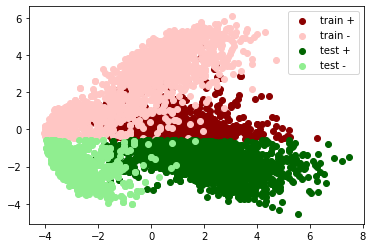

In [ ]:
plt.scatter(X_pca_train_1[:, 0], X_pca_train_1[:, 1], color="#8B0000", label='train +')
plt.scatter(X_pca_train_2[:, 0], X_pca_train_2[:, 1], color="#ffc6c4", label='train -')
plt.scatter(X_pca_test_1[:, 0], X_pca_test_1[:, 1], color="#006400", label='test +')
plt.scatter(X_pca_test_2[:, 0], X_pca_test_2[:, 1], color="#90EE90", label='test - ')
plt.legend()

In [ ]:
len(X_pca_test) / len(X_pca_train)

1.0009614724263443

#### LOG

In [ ]:
from os.path import exists

r_st = torch.ones(Y[train_idx].shape)
tmp_X = torch.FloatTensor(X[train_idx])
tmp_Y = torch.FloatTensor(Y[train_idx])

model = rba_train(tmp_X, tmp_Y, r_st, r_st, lr = 0.002, max_itr=8000)

Grad avg: 9.834551811218262. Grad max: 2680.433837890625
Grad avg: 0.1416538804769516. Grad max: 58.348941802978516
Grad avg: 0.056860897690057755. Grad max: 26.568937301635742
Grad avg: 0.02574307844042778. Grad max: 15.447914123535156
Grad avg: 0.011919469572603703. Grad max: 8.993751525878906
Grad avg: 0.006580065935850143. Grad max: 5.880842208862305
Grad avg: 0.0041084797121584415. Grad max: 3.6958656311035156
Grad avg: 0.0026469803415238857. Grad max: 2.401318311691284
Grad avg: 0.0016488569090142846. Grad max: 1.667419672012329


Target Loss: 0.4211235046386719. Target Accuracy: 0.8845968842506409
ECE: 0.2829802504833628
5 5


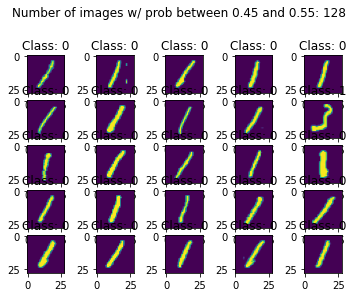

In [ ]:
loss, outputs, acc = log_test(model, torch.FloatTensor(X[test_idx]), torch.FloatTensor(Y[test_idx]), torch.ones(Y[test_idx].shape))
pred_y_pairs = np.concatenate((outputs.detach().numpy(), Y[test_idx]), axis=1)
ece = binary_ece(outputs, torch.FloatTensor(Y[test_idx]), n_bins=10)
print(f"ECE: {ece}")

plot_test_samples(X[test_idx], Y[test_idx], outputs)

#### RBA

In [ ]:
pca_kde = get_pca_kernel_density_estimator(X[train_idx], X[test_idx], bandwidth = 0.7)
r_st = pca_kde(X[train_idx])

In [ ]:
rba_model = rba_train(tmp_X, tmp_Y, r_st, torch.ones((tmp_Y.shape[0], 1)), lr = 0.008, max_itr=10000, weight_decay=0.005)

Grad avg: 11.051609992980957. Grad max: 1982.0302734375
Grad avg: 0.027565596625208855. Grad max: 10.897534370422363
Grad avg: 0.014587154611945152. Grad max: 8.115497589111328
Grad avg: 0.0034039851743727922. Grad max: 2.2708280086517334
Grad avg: 0.003890137653797865. Grad max: 2.054633140563965
Grad avg: 0.0027457736432552338. Grad max: 0.5701853632926941
Grad avg: 0.0023323262576013803. Grad max: 0.34300804138183594
Grad avg: 0.0008748727268539369. Grad max: 0.2020047903060913


Target Loss: 0.4250812530517578. Target Accuracy: 0.9433276057243347
ECE:  0.35571346039070684
5 5


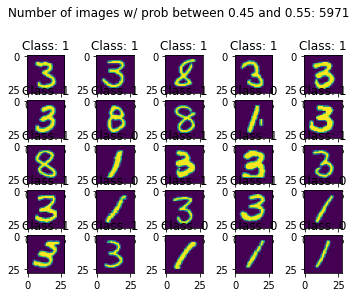

In [ ]:
r_st = pca_kde(X[test_idx])
loss, outputs, acc = log_test(rba_model, torch.FloatTensor(X[test_idx]), torch.FloatTensor(Y[test_idx]), r_st)
pred_y_pairs = np.concatenate((outputs.detach().numpy(), Y[test_idx]), axis=1)
ece = binary_ece(outputs, torch.FloatTensor(Y[test_idx]), n_bins=10)
print("ECE: ", ece)

plot_test_samples(X[test_idx], Y[test_idx], outputs, dev_from_mean = 0.05)

#### Size accumulation performance

In [ ]:
results = size_acc_perform(torch.Tensor(X[train_idx]), torch.Tensor(Y[train_idx]), torch.Tensor(X[test_idx]), torch.Tensor(Y[test_idx]))

1 / 10
Grad avg: 1.302848219871521. Grad max: 325.45562744140625
Grad avg: 0.000859046820551157. Grad max: 1.726575493812561
Target Loss: 1.4719350337982178. Target Accuracy: 0.7953344583511353
Grad avg: 26.671215057373047. Grad max: 5209.7939453125
Grad avg: 0.020388036966323853. Grad max: 7.909692287445068
Grad avg: 0.0049719600938260555. Grad max: 2.1263437271118164
Grad avg: 0.0019136419286951423. Grad max: 0.8398217558860779
Grad avg: 0.0008907478186301887. Grad max: 0.3982771635055542
Target Loss: 0.060814861208200455. Target Accuracy: 0.9875156283378601
Grad avg: 26.01810646057129. Grad max: 5331.1103515625
Grad avg: 0.020533135160803795. Grad max: 10.426422119140625
Grad avg: 0.0063219149596989155. Grad max: 2.9186370372772217
Grad avg: 0.003400791436433792. Grad max: 1.2624762058258057
Grad avg: 0.0023477214854210615. Grad max: 0.6743790507316589
Target Loss: 0.028514372184872627. Target Accuracy: 0.9912609457969666
Grad avg: 36.57817459106445. Grad max: 7139.14306640625
Grad 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


2 / 10
Grad avg: 3.944871664047241. Grad max: 1088.681884765625
Grad avg: 0.004108165390789509. Grad max: 2.8027477264404297
Grad avg: 0.000652612594421953. Grad max: 0.692524790763855
Target Loss: 0.8413538932800293. Target Accuracy: 0.8288850784301758
Grad avg: 19.120067596435547. Grad max: 4484.2841796875
Grad avg: 0.019425861537456512. Grad max: 10.603676795959473
Grad avg: 0.005300312303006649. Grad max: 2.8262102603912354
Grad avg: 0.0020988122560083866. Grad max: 1.1408389806747437
Grad avg: 0.0009925882332026958. Grad max: 0.5479353070259094
Target Loss: 0.08177073299884796. Target Accuracy: 0.9822654724121094
Grad avg: 20.65747833251953. Grad max: 3606.583984375
Grad avg: 0.02026860974729061. Grad max: 9.669713973999023
Grad avg: 0.006816466338932514. Grad max: 2.921478033065796
Grad avg: 0.0036875163204967976. Grad max: 1.4302759170532227
Grad avg: 0.0025574236642569304. Grad max: 0.8443752527236938
Target Loss: 0.04392252862453461. Target Accuracy: 0.986270010471344
Grad avg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


3 / 10
Grad avg: 5.458902359008789. Grad max: 1638.1619873046875
Grad avg: 0.004432570654898882. Grad max: 3.356144666671753
Grad avg: 0.0011623247992247343. Grad max: 1.297031283378601
Grad avg: 0.0005501573323272169. Grad max: 0.6409510374069214
Target Loss: 0.7409209609031677. Target Accuracy: 0.8367753028869629
Grad avg: 22.69882583618164. Grad max: 3570.79638671875
Grad avg: 0.023666009306907654. Grad max: 12.627423286437988
Grad avg: 0.00670778239145875. Grad max: 3.457897901535034
Grad avg: 0.0026693299878388643. Grad max: 1.3740073442459106
Grad avg: 0.0012681431835517287. Grad max: 0.646133303642273
Target Loss: 0.07711534947156906. Target Accuracy: 0.9830955862998962
Grad avg: 11.220386505126953. Grad max: 2588.416259765625
Grad avg: 0.020519385114312172. Grad max: 13.345463752746582
Grad avg: 0.007170483935624361. Grad max: 3.9655745029449463
Grad avg: 0.004079446196556091. Grad max: 1.8409340381622314
Grad avg: 0.007477796170860529. Grad max: 1.3988620042800903
Target Loss:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


4 / 10
Grad avg: 4.639098167419434. Grad max: 1089.18017578125
Grad avg: 0.005148923024535179. Grad max: 4.382816314697266
Grad avg: 0.0015743382973596454. Grad max: 1.5734058618545532
Grad avg: 0.0007180250831879675. Grad max: 0.9177365303039551
Target Loss: 0.7430033683776855. Target Accuracy: 0.8570154309272766
Grad avg: 17.0170955657959. Grad max: 4676.18701171875
Grad avg: 0.027208123356103897. Grad max: 21.61252784729004
Grad avg: 0.008422293700277805. Grad max: 6.232065200805664
Grad avg: 0.0034831631928682327. Grad max: 2.5882821083068848
Grad avg: 0.0016653597122058272. Grad max: 1.260332703590393
Target Loss: 0.045807916671037674. Target Accuracy: 0.9857773184776306
Grad avg: 19.35329818725586. Grad max: 4007.086181640625
Grad avg: 0.02780456840991974. Grad max: 12.923834800720215
Grad avg: 0.00854456052184105. Grad max: 3.9304869174957275
Grad avg: 0.004948502406477928. Grad max: 1.8217357397079468
Grad avg: 0.058569032698869705. Grad max: 6.532752990722656
Target Loss: 0.02

KeyboardInterrupt: ignored

In [ ]:
log_result, rba_result = results

In [ ]:
iter = [i for i in range(1, len(log_result) + 1)]

log_ece = [result['ece'] for result in log_result]
log_prec = [result['precision'] for result in log_result]
log_recall = [result['recall'] for result in log_result]
log_f1 = [result['f1'] for result in log_result]

rba_ece = [result['ece'] for result in rba_result]
rba_prec = [result['precision'] for result in rba_result]
rba_recall = [result['recall'] for result in rba_result]
rba_f1 = [result['f1'] for result in rba_result]

fig, ax = plt.subplots(4, 1)
fig.tight_layout()

ax[0].set_title('ECE')
ax[0].plot(iter, log_ece, label='log')
ax[0].plot(iter, rba_ece, label='rba')
ax[0].legend(loc="upper right")

ax[1].set_title('Precision')
ax[1].plot(iter, log_prec, label='log')
ax[1].plot(iter, rba_prec, label='rba')

ax[2].set_title('Recall')
ax[2].plot(iter, log_recall, label='log')
ax[2].plot(iter, rba_recall, label='rba')

ax[3].set_title('F1 score')
ax[3].plot(iter, log_f1, label='log')
ax[3].plot(iter, rba_f1, label='rba')
ax[3].set_xlabel('K folds of training data')

### Covariate shift determined by PCA gaussian sampling

For this experiment, I apply PCA on combined train / test set. 

In [ ]:
from sklearn import decomposition
from sklearn.neighbors import NearestNeighbors

train_X_flattened = torch.flatten(torch.Tensor(train_X), start_dim=1)
test_X_flattened = torch.flatten(torch.Tensor(test_X), start_dim=1)

X = np.concatenate((train_X_flattened, test_X_flattened), axis=0)
Y = np.concatenate((train_Y, test_Y))

pca = decomposition.PCA()
pca.n_components = 2
pca_X = pca.fit_transform(X)

In [ ]:
from scipy.stats import multivariate_normal

mvn_s = multivariate_normal(mean = [-1.25, 0], cov = [[1, -0.4], [-0.4, 1]] )
mvn_v = multivariate_normal(mean = [-0.3, 0.5], cov = [[2, 1], [1, 2]])

In [ ]:
n = 1000
gauss_pca_train = mvn_s.rvs(n)
gauss_pca_test = mvn_v.rvs(n)

In [ ]:
assert gauss_pca_train.shape[1] == pca_X.shape[1]

In [ ]:
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(pca_X)

In [ ]:
distances, train_indices = nbrs.kneighbors(gauss_pca_train)
train_indices = train_indices.reshape(-1)
train_indices = np.unique(train_indices)
print(len(train_indices))

873


In [ ]:
distances, test_indices = nbrs.kneighbors(gauss_pca_test)
test_indices = test_indices.reshape(-1)
print(len(test_indices))

# remove indices that intersect!
test_indices = np.setdiff1d(test_indices, np.intersect1d(train_indices, test_indices))
print(len(test_indices))

1000
848


In [ ]:
X_pca_train = pca_X[train_indices]
Y_pca_train = Y[train_indices].flatten()

X_pca_train_1 = X_pca_train[(Y_pca_train == 1)]
X_pca_train_2 = X_pca_train[Y_pca_train == 0]

X_pca_test = pca_X[test_indices]
Y_pca_test = Y[test_indices].flatten()

X_pca_test_1 = X_pca_test[Y_pca_test == 1]
X_pca_test_2 = X_pca_test[Y_pca_test == 0]

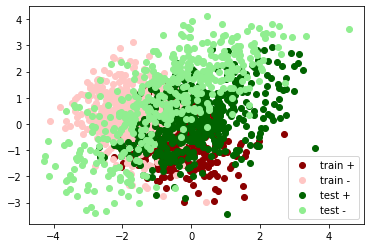

In [ ]:
plt.scatter(X_pca_train_1[:, 0], X_pca_train_1[:, 1], color="#8B0000", label='train +')
plt.scatter(X_pca_train_2[:, 0], X_pca_train_2[:, 1], color="#ffc6c4", label='train -')
plt.scatter(X_pca_test_1[:, 0], X_pca_test_1[:, 1], color="#006400", label='test +')
plt.scatter(X_pca_test_2[:, 0], X_pca_test_2[:, 1], color="#90EE90", label='test - ')
plt.legend()

In [ ]:
train_X = torch.Tensor(X[train_indices])
train_Y = torch.Tensor(Y[train_indices])
test_X = torch.Tensor(X[test_indices])
test_Y = torch.Tensor(Y[test_indices])

f"Training size: {len(train_X)}. Test size: {len(test_X)}"

'Training size: 873. Test size: 848'

In [ ]:
n_train_pos = int(sum(train_Y).item())
print(f"Train Positive: {n_train_pos} Train negative: {len(train_X) - n_train_pos}")

Train Positive: 438 Train negative: 435


In [ ]:
n_test_pos = int(sum(test_Y).item())
print(f"Test Positive: {n_test_pos} Test negative: {len(test_X) - n_test_pos}")

Test Positive: 433 Test negative: 415


#### LOG

In [ ]:
from os.path import exists

r_st = torch.ones(train_Y.shape)
model = rba_train(train_X, train_Y, r_st, r_st, lr = 0.002, max_itr=8000)

Grad avg: 0.5116952657699585. Grad max: 70.86502075195312
Grad avg: 0.0050504328683018684. Grad max: 2.795034170150757
Grad avg: 0.001287404098547995. Grad max: 1.0493332147598267
Grad avg: 0.0005861446261405945. Grad max: 0.6274591684341431


Target Loss: 1.058683156967163. Target Accuracy: 0.7995283007621765


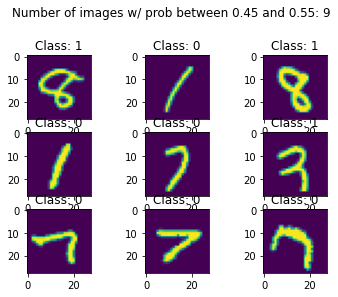

In [ ]:
loss, outputs, acc = log_test(model, test_X, test_Y, torch.ones(test_Y.shape))

plot_test_samples(test_X, test_Y, outputs)

Target Loss: 1.058683156967163. Target Accuracy: 0.7995283007621765


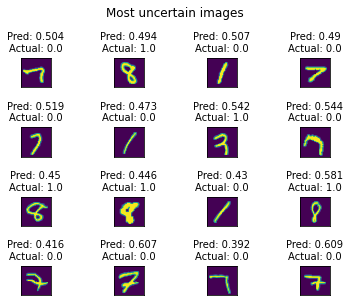

In [ ]:
loss, outputs, acc = log_test(model, test_X, test_Y, torch.ones(test_Y.shape))

plot_test_uncertain_samples(test_X, test_Y, outputs)

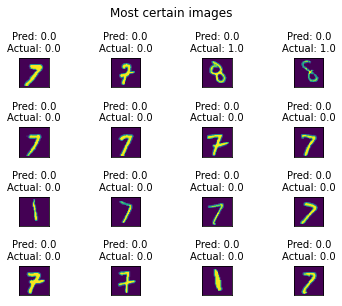

In [ ]:
plot_test_certain_samples(test_X, test_Y, outputs)

#### RBA

In [ ]:
lrdr = get_lrdr_estimator(train_X, test_X)
r_st = lrdr(train_X)

Grad avg: 0.31255125999450684. Grad max: 9.407883644104004
Grad avg: 0.000819435459561646. Grad max: 0.7478271126747131
Target Loss: 1.6935104131698608. Target Accuracy: 0.6767441630363464
Grad avg: 0.827908456325531. Grad max: 228.70289611816406
Grad avg: 0.003612640779465437. Grad max: 1.3926739692687988
Grad avg: 0.0023296999279409647. Grad max: 0.5375396609306335
Grad avg: 0.0017636024858802557. Grad max: 0.37737295031547546
Grad avg: 0.0016068137483671308. Grad max: 0.26791319251060486
Target Loss: 1.5433619022369385. Target Accuracy: 0.6767441630363464
Grad avg: 0.645547091960907. Grad max: 99.37957000732422
Grad avg: 0.00938104186207056. Grad max: 1.5628405809402466
Grad avg: 0.006777825765311718. Grad max: 0.8686453104019165
Grad avg: 0.0065328520722687244. Grad max: 0.6562654972076416
Grad avg: 0.006447929888963699. Grad max: 0.5261934399604797
Target Loss: 1.205336332321167. Target Accuracy: 0.6930232644081116
Grad avg: 0.3828015923500061. Grad max: 81.15248107910156
Grad avg

In [ ]:
rba_model = rba_train(train_X, train_Y, r_st, torch.ones(train_Y.shape), lr = 0.002, max_itr=10000, weight_decay=0.001)

Grad avg: 1.6515681743621826. Grad max: 437.72882080078125
Grad avg: 0.0011374525493010879. Grad max: 0.5087697505950928
Grad avg: 0.0013362953905016184. Grad max: 0.31862545013427734
Grad avg: 0.0004426224040798843. Grad max: 0.12796801328659058


Target Loss: 8.729255676269531. Target Accuracy: 0.0
Target Loss: 0.6929767727851868. Target Accuracy: 0.8160377144813538


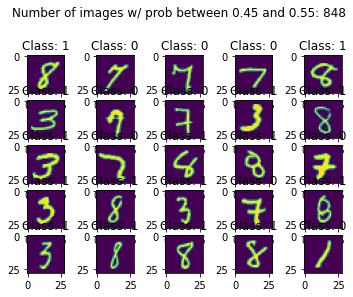

In [ ]:
r_st = lrdr(test_X)
loss, outputs, acc = log_test(rba_model, test_X, test_Y, r_st)

plot_test_samples(test_X, test_Y, outputs)

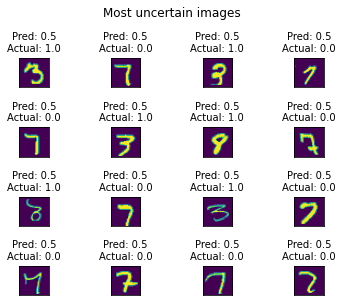

In [ ]:
plot_test_uncertain_samples(test_X, test_Y, outputs)

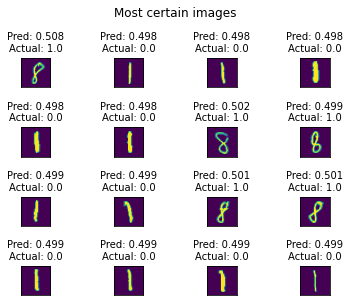

In [ ]:
plot_test_certain_samples(test_X, test_Y, outputs)

### Covariate shift different ratios of numbers within test vs train

In [ ]:
n = 1000 # TODO: n = 10, 20, 30? Make sure accuracy decreases
test_data_3 = (mnist_testset.data[(mnist_testset.targets == 3)])
test_data_8 = mnist_testset.data[(mnist_testset.targets == 8)]

test_data_38 = np.concatenate((test_data_3, test_data_8), dtype = float)
test_data_38_labels = np.concatenate((np.ones((len(test_data_3), 1)) * 3, (np.ones((len(test_data_8), 1)) * 8)))

test_data_1 = mnist_testset.data[(mnist_testset.targets == 1)] 
test_data_7 = mnist_testset.data[(mnist_testset.targets == 7)]

test_data_17 = np.concatenate((test_data_1, test_data_7), dtype = float)
test_data_17_labels = np.concatenate((np.ones((len(test_data_1), 1)) * 1, (np.ones((len(test_data_7), 1)) * 7)))

curlyRatio = len(test_data_3) / len(test_data_8)
straightRatio = len(test_data_1) / len(test_data_7)

print(f"Ratio of 3:8 = {curlyRatio}. Ratio of 1:7 = {straightRatio}")

test_X = np.concatenate((test_data_38, test_data_17), dtype = float)
test_X /= 255.0
test_Y_detailed = np.concatenate((test_data_38_labels, test_data_17_labels))

test_X, test_Y_detailed = unison_shuffled_copies(test_X, test_Y_detailed)
test_Y = np.where(np.logical_or(test_Y_detailed == 3, test_Y_detailed == 8), 1, 0)

test_X = test_X[:n]
test_Y = test_Y[:n]
test_Y_detailed = test_Y_detailed[:n]

Ratio of 3:8 = 1.0369609856262834. Ratio of 1:7 = 1.1040856031128405


Text(0.5, 1.0, 'Digit: 3.0')

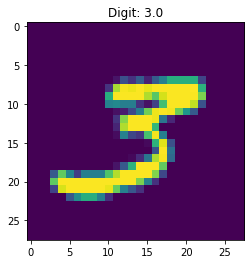

In [ ]:
# sanity check
i = 999
plt.imshow(test_X[i])
plt.title(f"Digit: {test_Y_detailed[i][0]}")

In [ ]:
n_test_pos = int(sum(test_Y).item())
print(f"Test Positive: {n_test_pos} Test negative: {n - n_test_pos}")

Test Positive: 460 Test negative: 540


In [ ]:
train_data_3 = (mnist_trainset.data[(mnist_trainset.targets == 3)])
train_data_3 = train_data_3[:int(0.01 * len(train_data_3))]

train_data_8 = mnist_trainset.data[(mnist_trainset.targets == 8)]

train_data_38 = np.concatenate((train_data_3, train_data_8), dtype = float)
train_data_38_labels = np.ones((len(train_data_38), 1))

train_data_1 = mnist_trainset.data[(mnist_trainset.targets == 1)] 
train_data_7 = mnist_trainset.data[(mnist_trainset.targets == 7)]
train_data_7 = train_data_7[:int(0.01 * len(train_data_7))]

train_data_17 = np.concatenate((train_data_1, train_data_7), dtype = float)
train_data_17_labels = np.zeros((len(train_data_17), 1))

curlyRatio = len(train_data_3) / len(train_data_8)
straightRatio = len(train_data_1) / len(train_data_7)

print(f"Ratio of 3:8 = {curlyRatio}. Ratio of 1:7 = {straightRatio}")

train_X = np.concatenate((train_data_38, train_data_17), dtype = float)
train_X /= 255.0
train_Y = np.concatenate((train_data_38_labels, train_data_17_labels))

train_X, train_Y = unison_shuffled_copies(train_X, train_Y)
train_X = train_X[:n]
train_Y = train_Y[:n]

Ratio of 3:8 = 0.01042556827892668. Ratio of 1:7 = 108.74193548387096


In [ ]:
n_train_pos = int(sum(train_Y).item())
print(f"Train Positive: {n_train_pos} Train negative: {n - n_train_pos}")

Train Positive: 462 Train negative: 538


In [ ]:
train_X_flattened = torch.flatten(torch.Tensor(train_X), start_dim=1)
test_X_flattened = torch.flatten(torch.Tensor(test_X), start_dim=1)
train_Y = torch.FloatTensor(train_Y)
test_Y = torch.FloatTensor(test_Y)

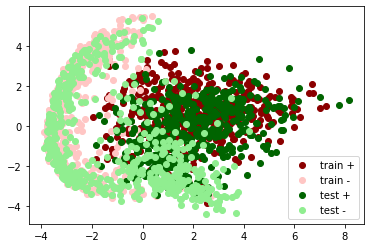

In [ ]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.n_components = 2
X = np.concatenate((train_X_flattened, test_X_flattened))

n_train = len(train_X_flattened)
n_test = len(test_X_flattened)

Y = np.concatenate((train_Y, test_Y))
pca_X = pca.fit_transform(X)
X_pca_train = pca_X[:n_train]
Y_pca_train = Y[:n_train].flatten()

X_pca_train_1 = X_pca_train[(Y_pca_train == 1)]
X_pca_train_2 = X_pca_train[Y_pca_train == 0]

X_pca_test = pca_X[n_train:]
Y_pca_test = Y[n_train:].flatten()

X_pca_test_1 = X_pca_test[Y_pca_test == 1]
X_pca_test_2 = X_pca_test[Y_pca_test == 0]
plt.scatter(X_pca_train_1[:, 0], X_pca_train_1[:, 1], color="#8B0000", label='train +')
plt.scatter(X_pca_train_2[:, 0], X_pca_train_2[:, 1], color="#ffc6c4", label='train -')
plt.scatter(X_pca_test_1[:, 0], X_pca_test_1[:, 1], color="#006400", label='test +')
plt.scatter(X_pca_test_2[:, 0], X_pca_test_2[:, 1], color="#90EE90", label='test - ')
plt.legend()

4 4


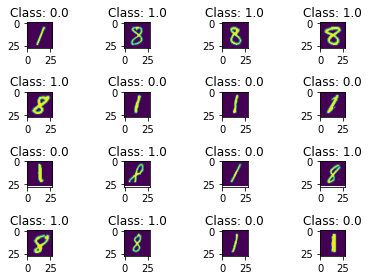

In [ ]:
plot_train_samples(train_X, train_Y)

4 4


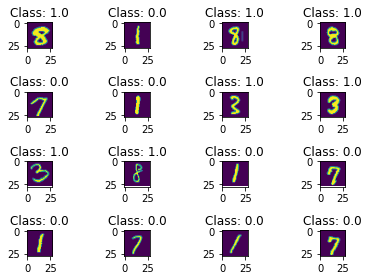

In [ ]:
plot_train_samples(test_X, test_Y)

#### LOG

In [ ]:
from os.path import exists

r_st = torch.ones(train_Y.shape)

model = rba_train(train_X_flattened, train_Y, r_st, r_st, lr = 0.002, max_itr=10000)

Grad avg: 0.9291321635246277. Grad max: 63.70247268676758
Grad avg: 0.004280338529497385. Grad max: 2.423997640609741
Grad avg: 0.0011172326048836112. Grad max: 1.2872166633605957
Grad avg: 0.0005424692644737661. Grad max: 1.0625553131103516


Target Loss: 1.0913574695587158. Target Accuracy: 0.7829999923706055


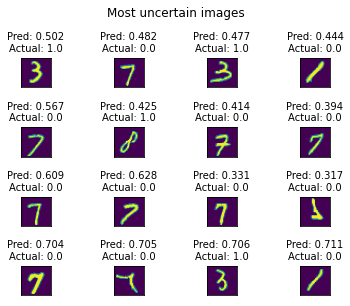

In [ ]:
loss, outputs, acc = log_test(model, test_X_flattened, test_Y, torch.ones(test_Y.shape))
pred_y_pairs = np.concatenate((outputs.detach().numpy(), test_Y), axis=1)

plot_test_uncertain_samples(test_X, test_Y, outputs)

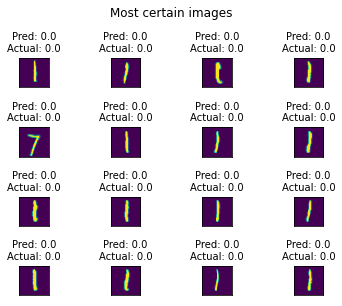

In [ ]:
plot_test_certain_samples(test_X, test_Y, outputs)

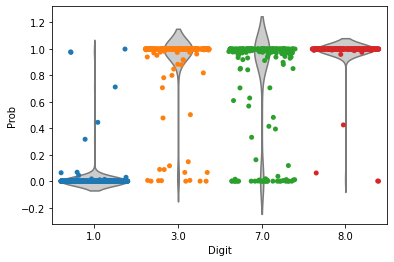

In [ ]:
import seaborn as sns
import pandas as pd

ones = outputs[test_Y_detailed == 1].unsqueeze(1).detach().numpy()
ones = np.concatenate((ones, np.ones(ones.shape)), axis = 1)

threes = outputs[test_Y_detailed == 3].unsqueeze(1).detach().numpy()
threes = np.concatenate((threes, np.ones(threes.shape) * 3), axis = 1)

sevens = outputs[test_Y_detailed == 7].unsqueeze(1).detach().numpy()
sevens = np.concatenate((sevens, np.ones(sevens.shape) * 7), axis = 1)

eights = outputs[test_Y_detailed == 8].unsqueeze(1).detach().numpy()
eights = np.concatenate((eights, np.ones(eights.shape) * 8), axis = 1)

all_digits = np.concatenate((ones, threes, sevens, eights), axis = 0)

df = pd.DataFrame(all_digits, columns = ['Prob', 'Digit'])
ax = sns.violinplot(x="Digit", y="Prob", data=df,
                    inner=None, color=".8")
ax = sns.stripplot(x="Digit", y="Prob", data=df, jitter = 0.4)

#### RBA

In [ ]:
# lrdr = get_lrdr_estimator(train_X_flattened, test_X_flattened)
# r_st = lrdr(train_X_flattened)

kde = get_pca_kernel_density_estimator(train_X_flattened, test_X_flattened, bandwidth=0.4)
r_st = kde(train_X_flattened)

In [ ]:
rba_model = rba_train(train_X_flattened, train_Y, r_st, torch.ones(train_Y.shape), lr = 0.002, max_itr=10000, weight_decay=0.001)

Grad avg: 0.8034003376960754. Grad max: 133.24432373046875
Grad avg: 0.007301401346921921. Grad max: 4.594736576080322
Grad avg: 0.00280341156758368. Grad max: 2.165195941925049
Grad avg: 0.0016238171374425292. Grad max: 1.3256195783615112
Grad avg: 0.0010612282203510404. Grad max: 0.9845344424247742
Grad avg: 0.0007603742997162044. Grad max: 0.6854457259178162


Target Loss: 1.106729507446289. Target Accuracy: 0.8180000185966492


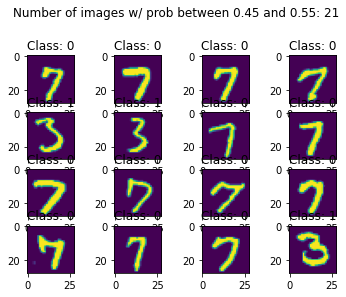

In [ ]:
# r_st = lrdr(test_X_flattened)
r_st = kde(test_X_flattened)

loss, outputs, acc = log_test(rba_model, test_X_flattened, test_Y, r_st)

plot_test_samples(test_X, test_Y, outputs)

In [ ]:
# plot the top 10 most uncertain images

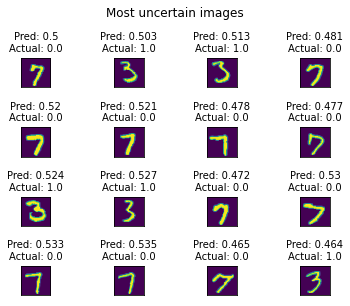

In [ ]:
plot_test_uncertain_samples(test_X,test_Y,outputs)

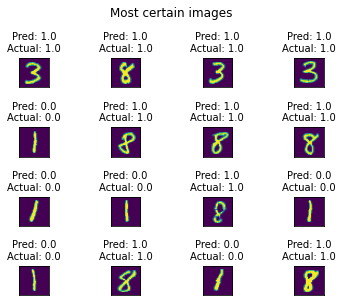

In [ ]:
plot_test_certain_samples(test_X,test_Y,outputs)

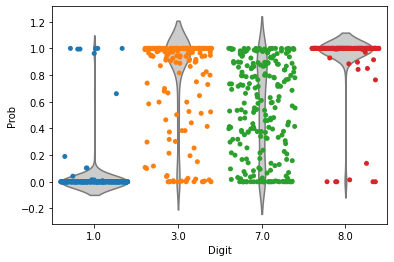

In [ ]:
import seaborn as sns
import pandas as pd

ones = outputs[test_Y_detailed == 1].unsqueeze(1).detach().numpy()
ones = np.concatenate((ones, np.ones(ones.shape)), axis = 1)

threes = outputs[test_Y_detailed == 3].unsqueeze(1).detach().numpy()
threes = np.concatenate((threes, np.ones(threes.shape) * 3), axis = 1)

sevens = outputs[test_Y_detailed == 7].unsqueeze(1).detach().numpy()
sevens = np.concatenate((sevens, np.ones(sevens.shape) * 7), axis = 1)

eights = outputs[test_Y_detailed == 8].unsqueeze(1).detach().numpy()
eights = np.concatenate((eights, np.ones(eights.shape) * 8), axis = 1)

all_digits = np.concatenate((ones, threes, sevens, eights), axis = 0)

df = pd.DataFrame(all_digits, columns = ['Prob', 'Digit'])
ax = sns.violinplot(x="Digit", y="Prob", data=df,
                    inner=None, color=".8")
ax = sns.stripplot(x="Digit", y="Prob", data=df, jitter = 0.4)

## 1 vs 7 Classification

In [ ]:
train_data_1 = mnist_trainset.data[
  (mnist_trainset.targets == 1)
] 
train_data_1_labels = np.zeros((len(train_data_1), 1))

train_data_7 = mnist_trainset.data[
  (mnist_trainset.targets == 7)
] 
train_data_7_labels = np.ones((len(train_data_7), 1))

train_X = np.concatenate((train_data_1, train_data_7), dtype = float)
train_X /= 255
train_Y = np.concatenate((train_data_1_labels, train_data_7_labels))

train_X, train_Y = unison_shuffled_copies(train_X, train_Y)

In [ ]:
plot_train_samples(train_X, train_Y)

In [ ]:
test_data_1 = mnist_testset.data[
  (mnist_testset.targets == 1)
] 
test_data_1_labels = np.zeros((len(test_data_1), 1))

test_data_7 = mnist_testset.data[
  (mnist_testset.targets == 7)
] 
test_data_7_labels = np.ones((len(test_data_7), 1))

test_X = np.concatenate((test_data_1, test_data_7), dtype = float)
test_X /= 255
test_Y = np.concatenate((test_data_1_labels, test_data_7_labels))

test_X, test_Y = unison_shuffled_copies(test_X, test_Y)

In [ ]:
plot_train_samples(test_X, test_Y)

### Covariate shift: Gaussian noise added to test set

In [ ]:
from skimage.util import random_noise, apply_parallel

test_X_noisy_gauss = test_X
# test_X_noisy_gauss = apply_parallel(random_noise, test_X, extra_keywords={
#       'mode':'gaussian',
#       'mean' : 0,
#       'var' : 0.2
#     })

In [ ]:
plot_train_samples(test_X_noisy_gauss, test_Y)

In [ ]:
train_X_flattened = torch.flatten(torch.Tensor(train_X), start_dim=1)
test_X_noisy_gauss_flattened = torch.flatten(torch.Tensor(test_X_noisy_gauss), start_dim=1)
train_Y = torch.FloatTensor(train_Y)
test_Y = torch.FloatTensor(test_Y)

In [ ]:
pca = decomposition.PCA()
pca.n_components = 2
X = np.concatenate((train_X_flattened, test_X_noisy_gauss_flattened))

n_train = len(train_X_flattened)
n_test = len(test_X_noisy_gauss_flattened)

Y = np.concatenate((train_Y, test_Y))
pca_X = pca.fit_transform(X)
X_pca_train = pca_X[:n_train]
Y_pca_train = Y[:n_train].flatten()

X_pca_train_1 = X_pca_train[(Y_pca_train == 1)]
X_pca_train_2 = X_pca_train[Y_pca_train == 0]

X_pca_test = pca_X[n_train:]
Y_pca_test = Y[n_train:].flatten()

X_pca_test_1 = X_pca_test[Y_pca_test == 1]
X_pca_test_2 = X_pca_test[Y_pca_test == 0]
plt.scatter(X_pca_train_1[:, 0], X_pca_train_1[:, 1], color="#8B0000", label='train +')
plt.scatter(X_pca_train_2[:, 0], X_pca_train_2[:, 1], color="#ffc6c4", label='train -')
plt.scatter(X_pca_test_1[:, 0], X_pca_test_1[:, 1], color="#006400", label='test +')
plt.scatter(X_pca_test_2[:, 0], X_pca_test_2[:, 1], color="#90EE90", label='test - ')
plt.legend()

#### LOG

In [ ]:
from os.path import exists

r_st = torch.ones(train_Y.shape)

model = rba_train(train_X_flattened, train_Y, r_st, r_st, lr = 0.002, max_itr=10000)

In [ ]:
loss, outputs, acc = log_test(model, test_X_noisy_gauss_flattened, test_Y, torch.ones(test_Y.shape))
pred_y_pairs = np.concatenate((outputs.detach().numpy(), test_Y), axis=1)
ece = binary_ece(pred_y_pairs, n_bins=1)
print(f"ECE: {ece}")

plot_test_samples(test_X, test_Y, outputs)

#### RBA

In [ ]:
pca_kde = get_pca_kernel_density_estimator(train_X_flattened, test_X_noisy_gauss_flattened)
r_st = pca_kde(train_X_flattened)

In [ ]:
rba_model = rba_train(train_X_flattened, train_Y, r_st, torch.ones(train_Y.shape), lr = 0.002, max_itr=10000, weight_decay=0.001)

In [ ]:
r_st = pca_kde(test_X_noisy_gauss_flattened)
loss, outputs, acc = log_test(rba_model, test_X_noisy_gauss_flattened, test_Y, r_st)
pred_y_pairs = np.concatenate((outputs.detach().numpy(), test_Y), axis=1)
ece = binary_ece(pred_y_pairs, n_bins=1)
print(f"ECE: {ece}")

plot_test_samples(test_X_noisy_gauss, test_Y, outputs)

###QMINST

In [ ]:
# https://github.com/facebookresearch/qmnist?utm_source=catalyzex.com 

In [ ]:
!wget https://raw.githubusercontent.com/facebookresearch/qmnist/main/qmnist.py

In [ ]:
from qmnist import QMNIST

In [ ]:
qall = QMNIST('_qmnist', what='nist', compat=False, download=True)

In [ ]:
# Written by employees of Cenus Bureau
X_train = np.array([np.array(qall[i][0])  for i in range(len(qall)) if qall[i][1][1] == 1])
Y_train = np.array([np.array(qall[i][1][0])  for i in range(len(qall)) if qall[i][1][1] == 1])

# Written by high school students
X_test = np.array([np.array(qall[i][0]) for i in range(len(qall)) if qall[i][1][1] == 4])
Y_test = np.array([np.array(qall[i][1][0])  for i in range(len(qall)) if qall[i][1][1] == 4])

In [ ]:
plot_train_samples(X_train, Y_train)

In [ ]:
X_s = X_train[np.logical_or(Y_train == 1, Y_train == 7)]
Y_s = Y_train[np.logical_or(Y_train == 1, Y_train == 7)]
Y_s = np.where(Y_s == 1, 0, 1)

X_t = X_test[np.logical_or(Y_test == 1, Y_test == 7)]
Y_t = Y_test[np.logical_or(Y_test == 1, Y_test == 7)]
Y_t = np.where(Y_t == 1, 0, 1)


In [ ]:
plot_train_samples(X_s, Y_s)

In [ ]:
plot_train_samples(X_t, Y_t)

In [ ]:
train_X_flattened = torch.flatten(torch.Tensor(X_s), start_dim=1)
train_Y = torch.Tensor(Y_s).unsqueeze(1)
test_X_flattened = torch.flatten(torch.Tensor(X_t), start_dim=1)
test_Y = torch.Tensor(Y_t).unsqueeze(1)

In [ ]:
pca = decomposition.PCA()
pca.n_components = 2
X = np.concatenate((train_X_flattened, test_X_flattened))

n_train = len(train_X_flattened)
n_test = len(test_X_flattened)

Y = np.concatenate((train_Y, test_Y))
pca_X = pca.fit_transform(X)
X_pca_train = pca_X[:n_train]
Y_pca_train = Y[:n_train].flatten()

X_pca_train_1 = X_pca_train[(Y_pca_train == 1)]
X_pca_train_2 = X_pca_train[Y_pca_train == 0]

X_pca_test = pca_X[n_train:]
Y_pca_test = Y[n_train:].flatten()

X_pca_test_1 = X_pca_test[Y_pca_test == 1]
X_pca_test_2 = X_pca_test[Y_pca_test == 0]
plt.scatter(X_pca_train_1[:, 0], X_pca_train_1[:, 1], color="#8B0000", label='train +')
plt.scatter(X_pca_train_2[:, 0], X_pca_train_2[:, 1], color="#ffc6c4", label='train -')
plt.scatter(X_pca_test_1[:, 0], X_pca_test_1[:, 1], color="#006400", label='test +')
plt.scatter(X_pca_test_2[:, 0], X_pca_test_2[:, 1], color="#90EE90", label='test - ')
plt.legend()

#### LOG

In [ ]:
from os.path import exists

r_st = torch.ones(train_Y.shape)
log_model = rba_train(train_X_flattened, train_Y, r_st, r_st, lr = 0.002, max_itr=10000)

In [ ]:
loss, outputs, acc = log_test(log_model, test_X_flattened, test_Y, torch.ones(test_Y.shape))
ece = binary_ece(outputs, test_Y, n_bins=10)
print(ece)
plot_test_samples(X_t, test_Y, outputs)

#### RBA

In [ ]:
lrdr =  get_lrdr_estimator(train_X_flattened, test_X_flattened)
r_st = lrdr(train_X_flattened)

In [ ]:
rba_model = rba_train(train_X_flattened, train_Y, r_st, torch.ones(train_Y.shape), lr = 0.002, max_itr=10000, weight_decay=0)

In [ ]:
r_st = lrdr(test_X_flattened)
loss, outputs, acc = log_test(rba_model, test_X_flattened, test_Y, r_st)
ece = binary_ece(outputs, test_Y, n_bins=10)
print(f"ECE: {ece}")

plot_test_samples(X_t, test_Y, outputs)

#### Size Accumulation performance

In [ ]:
results = size_acc_perform(train_X_flattened, train_Y, test_X_flattened, test_Y, n_folds = 5)